# Các điểm cần lưu ý ở Hồi quy đa biến
[BS. Vương Kiến Thanh](https://vuongkienthanh.github.io)

## Bài 2: Hồi quy đa biến giúp phát hiện những mối tương quan ẩn (masked relationship)

### Simulation: Giả sử ta có mối quan hệ sau đây:  
A -> B -> C   
A -> C  

Biến `C` là outcome, còn `A` và `B` là 2 variable mà ta thu thập (predictor).  
Ta sẽ thử hồi quy đơn biến với `C ~ A` và `C ~ B`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel as CGM

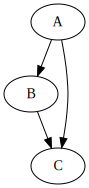

In [2]:
CGM(nodes=['A', 'B', 'C'],
    edges=[('A', 'B'), ('B', 'C'), ('A', 'C')]
).draw()

,A,B,C
A,1.000000,0.693961,-0.160649
B,0.693961,1.000000,0.401669
C,-0.160649,0.401669,1.000000


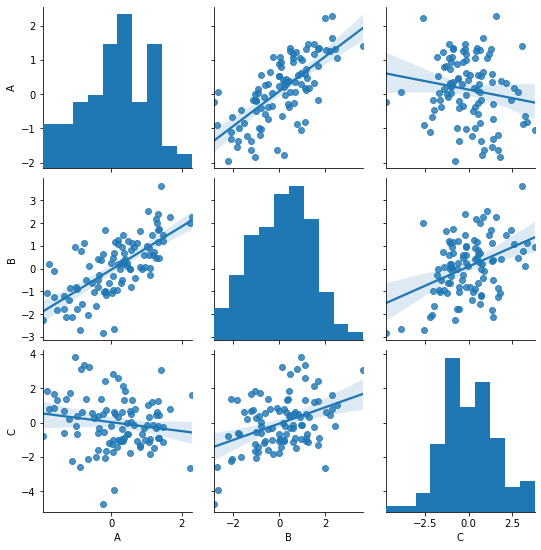

In [3]:
A = np.random.normal(loc=0, scale=1, size =100)
B = np.random.normal(loc=A, scale=1)
C = np.random.normal(loc=B-A, scale=1)

df = pd.DataFrame(np.vstack([A,B,C]).T, columns=['A','B','C'])
sns.pairplot(df, kind='reg')

df.corr()

Ta thấy:
- `A C` là corr âm gần zero
- `B C` là corr dương
- `A B` là corr dương

Hệ số hồi quy của đơn biến là:

In [4]:
from sklearn.linear_model import LinearRegression as OLS
m1 = OLS()
m1.fit(df[['A']], df['C'])

m2 = OLS()
m2.fit(df[['B']], df['C'])

m1.coef_, m2.coef_

(array([-0.25865489]), array([0.47556325]))

Hãy xem chuyện gì xảy ra với hồi quy đa biến `C ~ A + B`

In [5]:
m3 = OLS()
m3.fit(df[['A','B']], df['C'])
m3.coef_

array([-1.36462824,  1.17194396])

## Nhận xét:
Mới đầu khi thử mô hình đơn biến, kết quả hệ số hồi quy của `C~A` là gần bằng 0, của `C~B` là dương.  
Sau khi áp vào mô hình đa biến, kết quả hệ số của `A` là âm nhiều và  `B` cũng dương nhiều.

## Chuyện gì đã xảy ra:
Đây là một tình huống gọi là **masked relationship**. Nó xảy ra khi có 2 biến predictors cùng có tương quan với outcome, trong đó, một biến tương quan dương, một biến tương quan âm, và 2 predictors cùng tương quan với nhau.  

Mô hình hồi quy tuyến tính đa biến đã xác định đúng mối quan hệ này, loại trừ tình trạng mối tương quan bị ẩn khi mô hình chưa đủ và đúng biến trong quan hệ nhân quả.

## Visualize effect từ các biến predictors bằng *counterfactual plot*

In [6]:
import statsmodels.api as sm
def counterfactual_plot(x, y, df):
    fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)
    model1 = sm.OLS(df[y], sm.add_constant(df[[x]])).fit()
    sim_x = np.linspace(df[x].min(), df[x].max(),20)
    pred1 = model1.get_prediction(sm.add_constant(sim_x))
    ax[0].scatter(df[x], df[y])
    ax[0].plot(sim_x, pred1.predicted_mean)
    ax[0].fill_between(sim_x,
                     y1=pred1.predicted_mean - 2*pred1.se_mean,
                     y2=pred1.predicted_mean + 2*pred1.se_mean,
                     alpha=0.5, color='lightblue')
    ax[0].fill_between(sim_x,
                     y1=pred1.predicted_mean - 2*pred1.se_obs,
                     y2=pred1.predicted_mean + 2*pred1.se_obs,
                     alpha=0.1, color='k')
    
    model = sm.OLS(df[y], sm.add_constant(df.iloc[:,:-1])).fit()
    loc = list(df.columns).index(x)
    
    sim = pd.DataFrame(np.ones( (20,df.shape[1]-1)), columns=df.columns[:-1])
    sim[x] = np.linspace(df[x].min(), df[x].max(), 20)
    for c in df.columns[:-1]:
        if c != x:
            sim[c] = df[c].mean()
    sim = sm.add_constant(sim, has_constant='add')
    pred = model.get_prediction(sim)
    
    ax[1].plot(sim[x], pred.predicted_mean)
    ax[1].fill_between(sim[x],
                     y1=pred.predicted_mean - 2*pred.se_mean,
                     y2=pred.predicted_mean + 2*pred.se_mean,
                     alpha=0.5, color='lightblue')
    ax[1].fill_between(sim[x],
                     y1=pred.predicted_mean - 2*pred.se_obs,
                     y2=pred.predicted_mean + 2*pred.se_obs,
                     alpha=0.1, color='k')
    ax[0].set_title(f"{y} ~ {x}")
    ax[0].set_xlabel(x)
    ax[0].set_ylabel(y)
    half = " + ".join(list(df.columns)[:-1])
    model_name = f"{y} ~ {half}"
    ax[1].set_title(f"Total counterfactual effect of {x} on {y} holding others=mean data\n{model_name}")
    ax[1].set_xlabel(f"Manipulated {x}")
    plt.show()

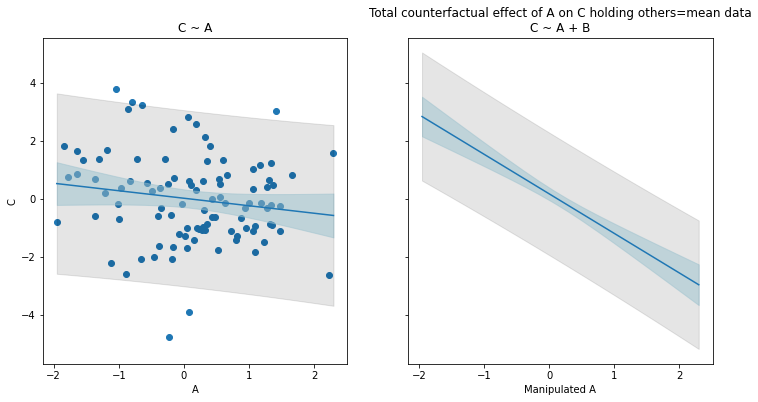

In [7]:
counterfactual_plot('A', 'C', df)

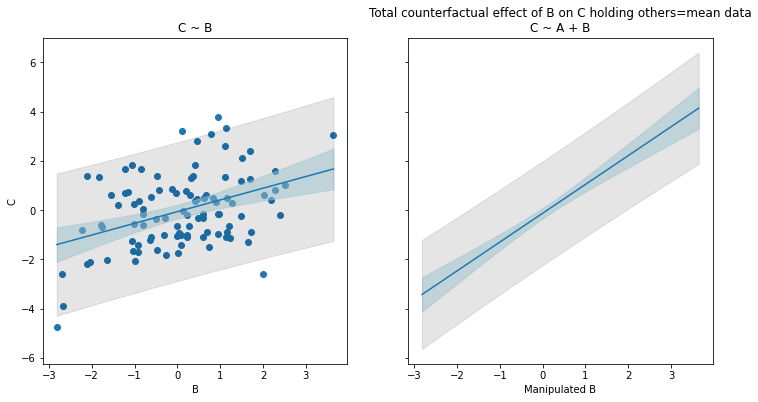

In [8]:
counterfactual_plot('B', 'C', df)

## Real data 

In [9]:
url = r"https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/milk.csv"
M = "mass"
N = "neocortex.perc"
K = "kcal.per.g"
data = pd.read_csv(url, sep=';')[[M,N,K]]
data.dropna(inplace=True)
data.head()

,mass,neocortex.perc,kcal.per.g
0,1.95,55.16,0.49
5,5.25,64.54,0.47
6,5.37,64.54,0.56
7,2.51,67.64,0.89
9,0.68,68.85,0.92


Predictors: `mass` và `neocortex.perc`  
Outcome: `kcal.per.g`  
Mỗi dòng tương ứng với một loài động vật.  

Mục tiêu của chúng ta là kiểm tra xem trọng lượng loài vật và diện tích bề mặt não có liên quan đến chất lượng của sữa hay không, được đại diện qua kcal trong sữa.

Một giả thuyết mà ta có thể đặt ra là:
- Bộ não lớn thì sẽ sản xuất sữa chất lượng hơn, để não có thể phát triển tốt.
- Tỉ lệ chất xám thì tương quan với trọng lượng.

Ta sẽ kiểm tra giả thuyết này với hồi quy tuyến tính đơn biến và đa biến.

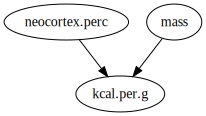

In [10]:
CGM(nodes=[M,N,K],
    edges=[(M,K), (N,K)]
).draw()

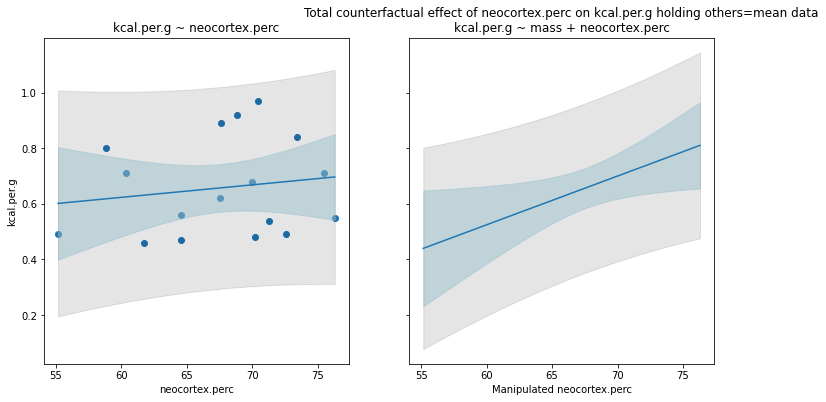

In [11]:
counterfactual_plot(N, K, data)

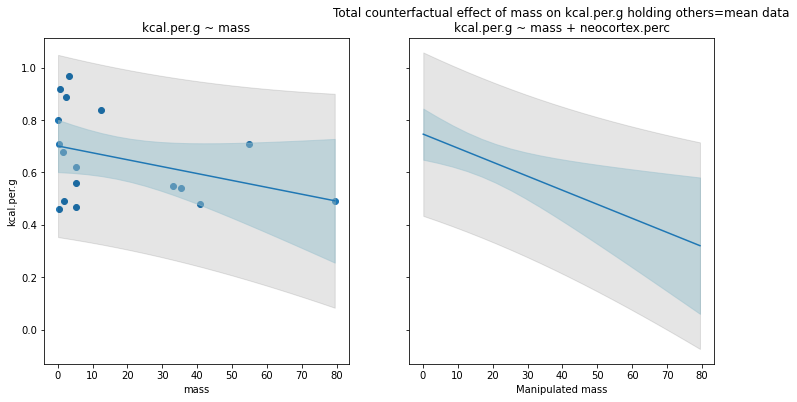

In [12]:
counterfactual_plot(M, K, data)

## Như vậy:
**Masking** đã xảy ra với 2 biến `neocortex.perc` và `mass` .  
Mô hình hồi quy đa biến đã phân biệt rất tốt mối quan hệ bị ẩn này.  
Thực vậy, mô hình này trả lời được các câu hỏi:
- Với cùng `mass`, loài vật có tỉ lệ chất xám nhiều hơn thì cho sữa tốt hơn.
- Với cùng `neocortex.perc`, loài vật càng nặng thì cho sữa kém hơn.

Các tương quan có thể xảy ra với 2 biến này là:

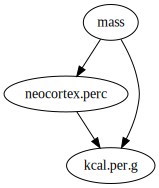

In [13]:
CGM(nodes=[M,N,K],
    edges=[(M,K), (N,K), (M,N)]
).draw()

Hoặc

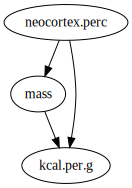

In [14]:
CGM(nodes=[M,N,K],
    edges=[(M,K), (N,K), (N,M)]
).draw()

Hoặc cũng có thể là:

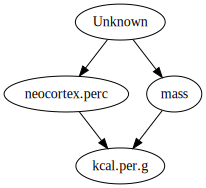

In [15]:
CGM(nodes=[M,N,K,"Unknown"],
    edges=[(M,K), (N,K), ("Unknown", M), ("Unknown", N)]
).draw()

## Để biết được quan hệ nhân quả nào là đúng thì ta phải có kiến thức chuyên ngành và thu thập nhiều biến số hơn.
Ta có thể liệt kê tất cả các quan hệ có thể xảy ra với cùng một tính chất về **liên quan độc lập có điều kiện** bằng cách dùng **MARKOV EQUIVALENCE**.

In [28]:
from itertools import combinations

def markov_equivalence(input_dag):
    independence = input_dag.get_all_independence_relationships()
    edges = list(input_dag.dag.edges)
    nodes = list(input_dag.dag.nodes)
    res = []
    for i in range(len(edges)+1):
        for j in combinations(range(len(edges)), i):
            edges2 = edges.copy()
            for elem in j:
                edges2[elem] = np.flip(edges2[elem])
            try:
                dag = CGM(nodes=nodes,edges=edges2)
                if dag.get_all_independence_relationships() == independence:
                    res += [dag]
            except AssertionError:
                pass
    print('Markov Equivalence set of origin DAG:')
    print('\tNodes:', end=" "); print(*nodes, sep=", ")
    print('\tEdges:', end=" "); print(*edges, sep=", ")
    print('\tConditional Independencies:', independence, end='\n\n')
    for idx, cgm in enumerate(res):
        print(f"CGM {idx} edges:\n{cgm.dag.edges}\n")
    return res

Markov Equivalence set of origin DAG:
	Nodes: mass, neocortex.perc, kcal.per.g
	Edges: ('mass', 'kcal.per.g'), ('neocortex.perc', 'kcal.per.g'), ('neocortex.perc', 'mass')
	Conditional Independencies: []

CGM 0 edges:
[('mass', 'kcal.per.g'), ('neocortex.perc', 'kcal.per.g'), ('neocortex.perc', 'mass')]

CGM 1 edges:
[('neocortex.perc', 'kcal.per.g'), ('neocortex.perc', 'mass'), ('kcal.per.g', 'mass')]

CGM 2 edges:
[('mass', 'kcal.per.g'), ('mass', 'neocortex.perc'), ('neocortex.perc', 'kcal.per.g')]

CGM 3 edges:
[('neocortex.perc', 'mass'), ('kcal.per.g', 'mass'), ('kcal.per.g', 'neocortex.perc')]

CGM 4 edges:
[('mass', 'kcal.per.g'), ('mass', 'neocortex.perc'), ('kcal.per.g', 'neocortex.perc')]

CGM 5 edges:
[('mass', 'neocortex.perc'), ('kcal.per.g', 'mass'), ('kcal.per.g', 'neocortex.perc')]



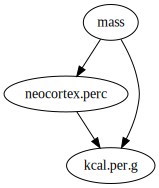

In [29]:
a = CGM(nodes=[M,N,K],
    edges=[(M,K), (N,K), (N,M)]
)
me = markov_equivalence(a)
me[2].draw()

## Nhận xét:
*Markov Equivalence set* chỉ hỗ trợ bạn tìm ra những mô hình nhân quả nào có cùng các mối liên quan **Độc lập có điều kiện** .  

Nhiệm vụ của bạn là loại trừ những mô hình vô lý bằng kiến thức bản thân, sau đó mới dùng đến các phương pháp thống kê.